# Cars

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
tsensor.__version__

'0.1b7'

In [3]:
df_cars = pd.read_csv("../data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
def carshow(m, b, X=df_cars.WGT, y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

## Brute force linear model

In [5]:
# brute force model parameter space search (m,b)
best = (1e100,0,0)
for m in np.linspace(-0.005,-.01,num=5):
    for b in np.linspace(42,47,num=5):
        y = m * df_cars.WGT + b
        mse = np.mean((y - df_cars.MPG)**2)
        if mse < best[0]:
            best = (mse,m,b)
        print(f"{m:4.3f},{b:4.3f} => MSE {mse:.1f}")
m = best[1]
b = best[2]
print(f"BEST {m:.3f}*x + {b:.3f}")

-0.005,42.000 => MSE 37.2
-0.005,43.250 => MSE 47.9
-0.005,44.500 => MSE 61.7
-0.005,45.750 => MSE 78.7
-0.005,47.000 => MSE 98.8
-0.006,42.000 => MSE 20.1
-0.006,43.250 => MSE 21.5
-0.006,44.500 => MSE 26.1
-0.006,45.750 => MSE 33.7
-0.006,47.000 => MSE 44.5
-0.007,42.000 => MSE 33.0
-0.007,43.250 => MSE 25.1
-0.007,44.500 => MSE 20.3
-0.007,45.750 => MSE 18.7
-0.007,47.000 => MSE 20.2
-0.009,42.000 => MSE 75.8
-0.009,43.250 => MSE 58.6
-0.009,44.500 => MSE 44.5
-0.009,45.750 => MSE 33.6
-0.009,47.000 => MSE 25.8
-0.010,42.000 => MSE 148.6
-0.010,43.250 => MSE 122.1
-0.010,44.500 => MSE 98.7
-0.010,45.750 => MSE 78.5
-0.010,47.000 => MSE 61.4
BEST -0.007*x + 45.750


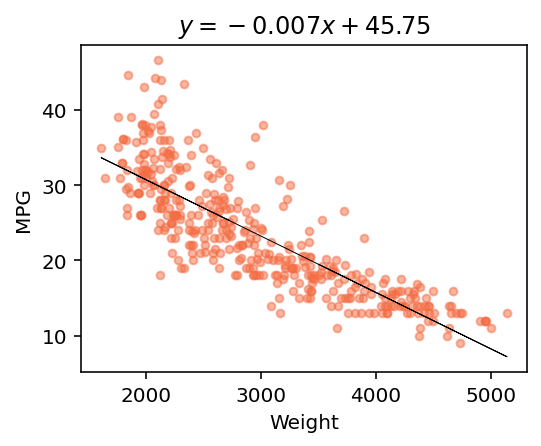

In [6]:
carshow(m, b)

## Linear model with numpy, one learning rate

### Manual gradient computation of loss function

use the sum, ignoring 1/n constant.

$$
loss = \sum_i^n E^2 \text{ where } E = \hat{y} - y = mx + b - y
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial m} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial m}\\
 & = & \sum_i^n E x\\
\end{array}
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial b} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial b}\\
 & = & \sum_i^n E\\
\end{array}
$$

Loss function is a saddle like this:

<img src="images/2d-loss.png" width="200">

Epoch     0 0.16,45.00: MSE loss   272600.413 MAE   502.02
Epoch    10 -0.01,45.00: MSE loss       18.788 MAE     3.26
LAST        -0.01,45.00: MSE loss       18.788 MAE     3.26


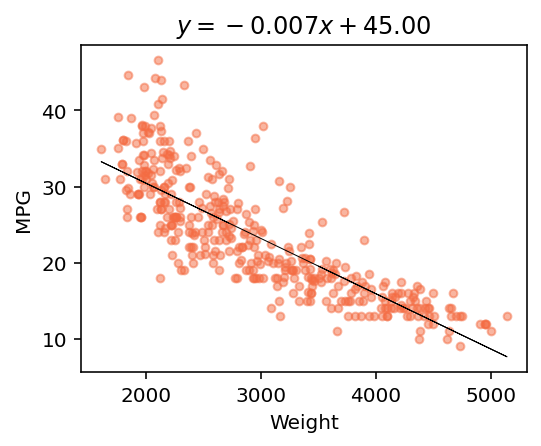

In [7]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)

# Randomly initialize weights
m = np.random.random(size=1)[0]
b = 45.0 # get it very close to an answer
learning_rate = .0000000003
nepochs=10
for epoch in range(nepochs+1):
    y_pred = m * X + b
    E = y_pred - y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Compute the gradient of loss with respect to m, b
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X, y)

## Linear model with standardized/normalized variables

Standardizing variables to be mean centered and with standard deviation one, improves convergence speed. Previously we had to choose a `b` that was very close to the answer.

### Standardize

The old but very useful article [Efficient BackProp by LeCun et al](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), describes why we need to standardize our X variables. I'm under the impression that getting all of the variances to 1.0 or at least similar, means we don't need learning rates per dimension (variable). The article indicates that we want the zero mean because "*any shift of the average input away from zero will bias the updates in a particular direction and thus slow down learning.*"  Consider the input layer to a network. We saw above that the derivative of the loss with respect to the $m$ slope parameter is the error, $E = y-\hat{y}$, times the $x_i$ input for variable $i$. LeCun points out that, if all inputs are positive, the $sign(E)$ dictates the direction we update the $m$ slopes. "*... these weights [$m$] can only all decrease or all increase together for a given input pattern. Thus, if a weight vector must change direction it can only do so by zigzagging which is inefficient and thus very slow.*"

In [8]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
X = (X-np.mean(X))/np.std(X)
y = np.array(df_cars.MPG).reshape(n,1)

0.9282750530445403 0.6816963303547928
Epoch     0 0.93,0.68: MSE loss      591.878 MAE    22.76
Epoch    10 -5.65,20.88: MSE loss       25.978 MAE     3.69
Epoch    20 -6.39,23.16: MSE loss       18.770 MAE     3.26
Epoch    30 -6.48,23.41: MSE loss       18.678 MAE     3.28
Epoch    40 -6.49,23.44: MSE loss       18.677 MAE     3.28
Epoch    50 -6.49,23.45: MSE loss       18.677 MAE     3.28
LAST        -6.49,23.45: MSE loss       18.677 MAE     3.28


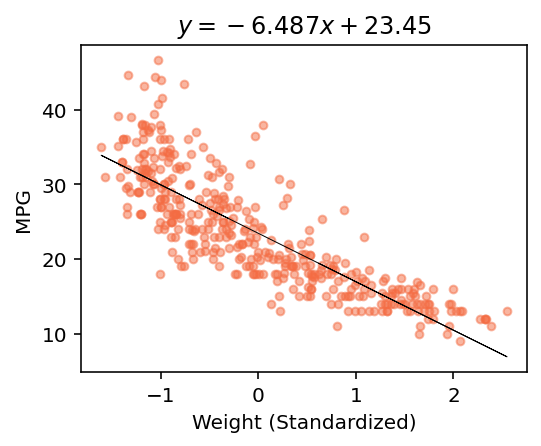

In [9]:
# Randomly initialize weights
m = np.random.random(size=1)[0]
b = np.random.random(size=1)[0]
print(m,b)
learning_rate = .0005 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=50
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X=X, y=df_cars.MPG)

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import colors 

def loss(X,y,m,b):
    y_pred = m * X + b
#     return mean_squared_error(y, y_pred)
    return np.mean((y.reshape(-1,1)-y_pred.reshape(-1,1))**2)

def linmodel_coeff(X,y):
    lm = LinearRegression(normalize=False, fit_intercept=True)
    lm.fit(X, y)
#     print(lm.intercept_, lm.coef_)
    b = lm.intercept_[0]
    m = lm.coef_[0][0]
    return m,b

def grid_pairs(mrange, brange, n=100):
    pairs = [(m,b) for m in np.linspace(*mrange,num=n)
                   for b in np.linspace(*brange,num=n)]
    return np.array(pairs)

def loss_plot(m, b, z, truth=None, zmax=None, ax=None):
    cmap = plt.get_cmap('coolwarm')
    if zmax is not None:
        z = np.clip(z,min(z),zmax)
#     if zmax is None:
#         zmax = max(z)
    norm = colors.Normalize(min(z),max(z))
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    if truth:
        tm,tb = truth
        ax.plot(tm, tb, 'x', ms=10, c='k')
    ax.scatter(m, b, s=30, c=cmap(norm(z)), alpha=1, marker='s')
    ax.set_xlabel("Slope m")
    ax.set_ylabel("Y-intercept b")
    ax.set_title("MSE linear model loss function")

def show(X, y, m, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

def explain(X, y, mrange, brange, normalize=False, zmax=None):
    if normalize:
        X = (X-np.mean(X))/np.std(X)

    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    m,b = linmodel_coeff(X,y)
    print(m,b,loss(X,y,m,b))
#     print(f"m = {m:.2f}, b = {b:.2f}")    
    pairs = grid_pairs(mrange, brange, n=50)
    z = np.array([loss(X,y,*pair) for pair in pairs])
    loss_plot(pairs[:,0], pairs[:,1], z, truth=(m,b), ax=axes[0], zmax=zmax)
    show(X, y, m, b, ax=axes[1])

-0.00764734245858457 46.21652431150987 18.676616404930005


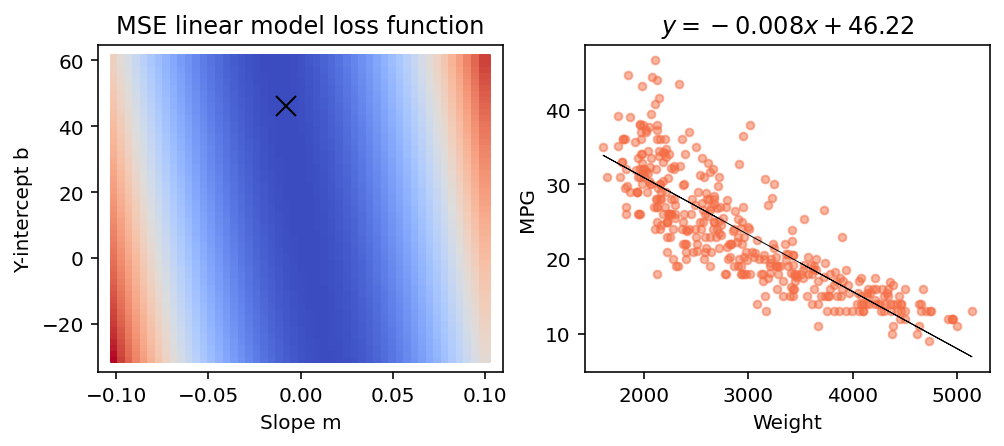

In [76]:
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)
explain(X, y, mrange = (-.1,.1), brange = (-30,60), zmax=None)

-6.487381674854015 23.445918359693877 18.67661640493001


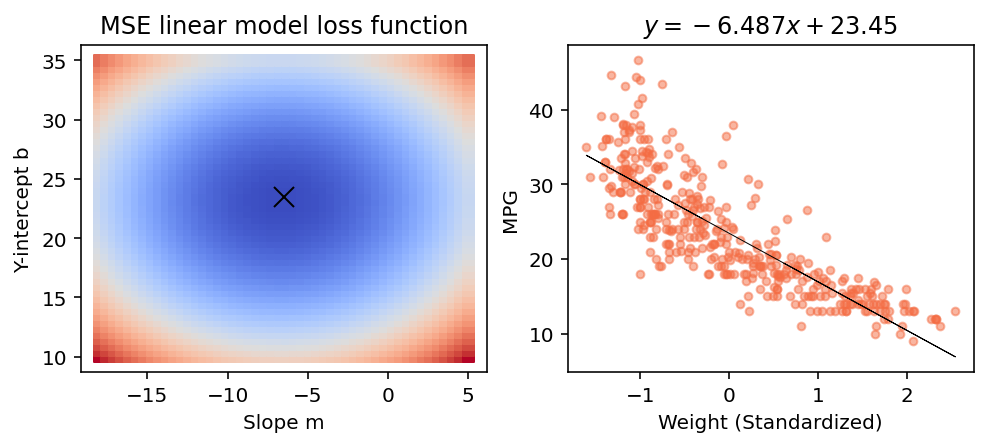

In [82]:
explain(X, y,
        mrange = (-18,5), brange = (10,35),
        normalize=True)

## Linear model with pytorch

In [27]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1).float()
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

Epoch     0 0.27,-0.15: MSE loss      621.364 MAE    23.60
Epoch    10 -5.76,20.91: MSE loss       25.632 MAE     3.67
Epoch    20 -6.42,23.17: MSE loss       18.757 MAE     3.26
Epoch    30 -6.49,23.42: MSE loss       18.678 MAE     3.28
LAST        -6.49,23.42: MSE loss       18.678 MAE     3.28


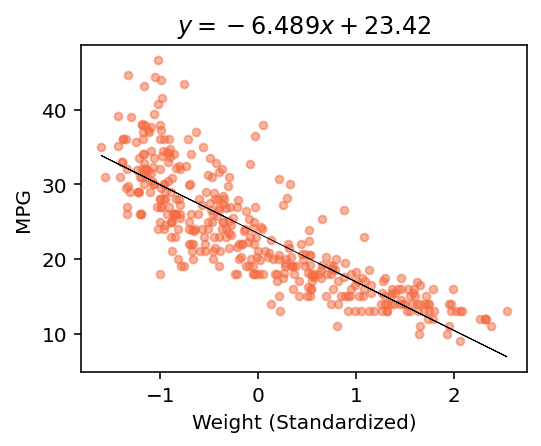

In [30]:
# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True) # too far away from correct answer for one learning rate
learning_rate = .1 # almost too fast for m, but incredibly slow for b.  Loss surface is a valley
nepochs=30
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
#     print(m.detach().item(), b.detach().item())
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X=X, y=df_cars.MPG)

## Linear model with pytorch using Adam optimizer

Epoch     0 -0.74,-0.11: MSE loss      606.318 MAE    23.55
Epoch    10 -7.88,18.76: MSE loss       42.564 MAE     5.26
Epoch    20 -5.81,28.78: MSE loss       47.625 MAE     6.13
Epoch    30 -6.77,26.39: MSE loss       27.406 MAE     4.34
Epoch    40 -6.52,21.93: MSE loss       20.962 MAE     3.41
Epoch    50 -6.32,22.28: MSE loss       20.062 MAE     3.32
Epoch    60 -6.69,24.05: MSE loss       19.080 MAE     3.38
Epoch    70 -6.40,23.78: MSE loss       18.796 MAE     3.31
LAST       -6.44,23.69: MSE loss       18.796 MAE     3.31


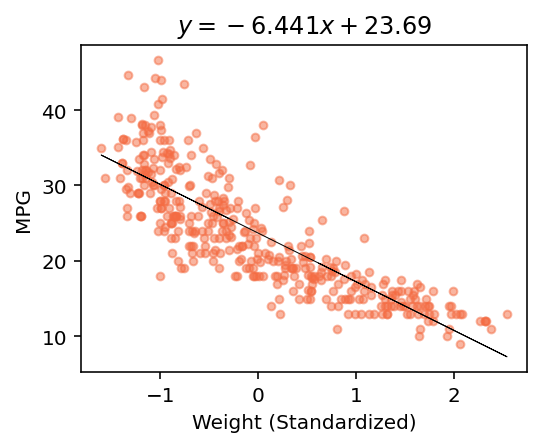

In [31]:
# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True)

learning_rate = 2
optimizer = torch.optim.Adam([m,b], lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients of w1, w2, ... with respect to loss
    optimizer.zero_grad()
    loss.backward() # autograd computes w1.grad, b1.grad, ...
    optimizer.step()
m = m.detach().item()
b = b.detach().item()
print(f"LAST       {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)

## Built-in Linear model with pytorch

Epoch   0 MSE loss      598.065 MAE    23.11
Epoch  10 MSE loss      198.271 MAE    13.31
Epoch  20 MSE loss       43.409 MAE     5.34
Epoch  30 MSE loss       20.158 MAE     3.47
Epoch  40 MSE loss       24.354 MAE     4.03
Epoch  50 MSE loss       21.348 MAE     3.69
Epoch  60 MSE loss       18.808 MAE     3.30
Epoch  70 MSE loss       18.868 MAE     3.29
LAST      MSE loss       18.868 MAE     3.29


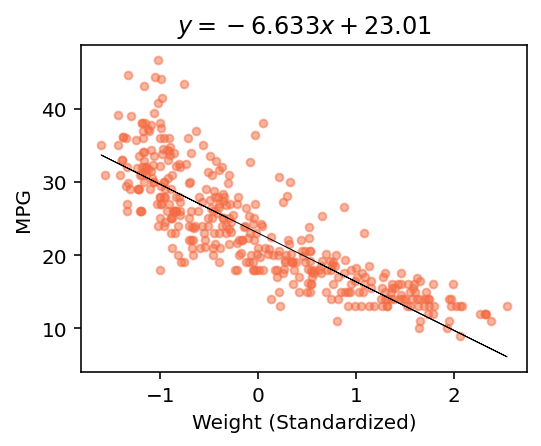

In [33]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

In [34]:
def mshow(model, X=df_cars.WGT, y=df_cars.MPG):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    plt.show()

In [35]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

### Without nonlinearity

Epoch    0 MSE loss      613.525 MAE    23.63
Epoch   10 MSE loss       59.178 MAE     6.61
Epoch   20 MSE loss       24.258 MAE     3.74
Epoch   30 MSE loss       27.360 MAE     4.46
Epoch   40 MSE loss       20.259 MAE     3.28
Epoch   50 MSE loss       19.702 MAE     3.42
Epoch   60 MSE loss       19.218 MAE     3.37
Epoch   70 MSE loss       18.731 MAE     3.30
Epoch   80 MSE loss       18.695 MAE     3.27
Epoch   90 MSE loss       18.704 MAE     3.28
Epoch  100 MSE loss       18.679 MAE     3.28
LAST       MSE loss       18.679 MAE     3.28


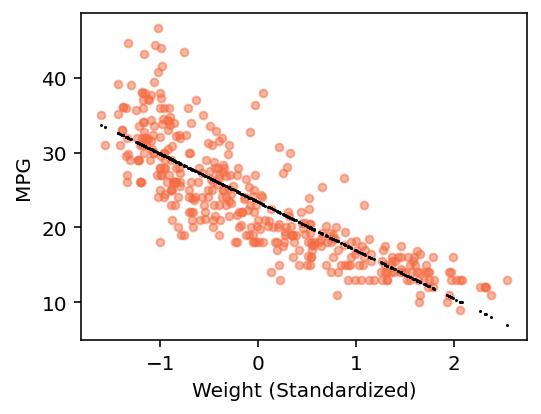

In [37]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG)

### With ReLU nonlinearity

Epoch    0 MSE loss      611.364 MAE    23.44
Epoch   10 MSE loss       19.862 MAE     3.19
Epoch   20 MSE loss       19.983 MAE     3.37
Epoch   30 MSE loss       20.425 MAE     3.55
Epoch   40 MSE loss       19.782 MAE     3.21
Epoch   50 MSE loss       18.262 MAE     3.15
Epoch   60 MSE loss       18.031 MAE     3.14
Epoch   70 MSE loss       18.082 MAE     3.14
Epoch   80 MSE loss       17.960 MAE     3.18
Epoch   90 MSE loss       17.891 MAE     3.14
Epoch  100 MSE loss       17.855 MAE     3.14
LAST       MSE loss       17.855 MAE     3.14


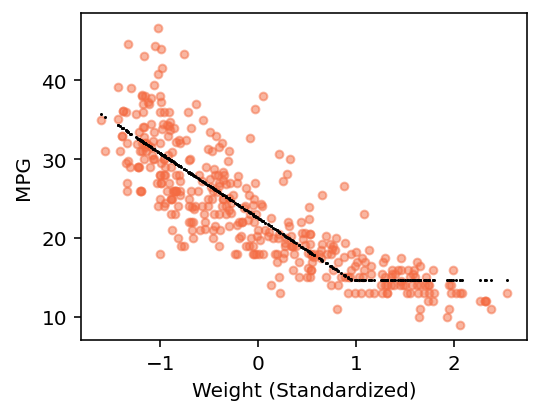

In [39]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG)

### With tanh nonlinearity

Epoch    0 MSE loss      600.414 MAE    23.18
Epoch   10 MSE loss      135.590 MAE     9.95
Epoch   20 MSE loss       62.836 MAE     6.53
Epoch   30 MSE loss       63.606 MAE     6.55
Epoch   40 MSE loss       64.464 MAE     6.80
Epoch   50 MSE loss       62.427 MAE     6.53
Epoch   60 MSE loss       61.279 MAE     6.60
Epoch   70 MSE loss       60.906 MAE     6.53
Epoch   80 MSE loss       60.805 MAE     6.56
Epoch   90 MSE loss       60.777 MAE     6.54
Epoch  100 MSE loss       60.769 MAE     6.55
LAST       MSE loss       60.769 MAE     6.55


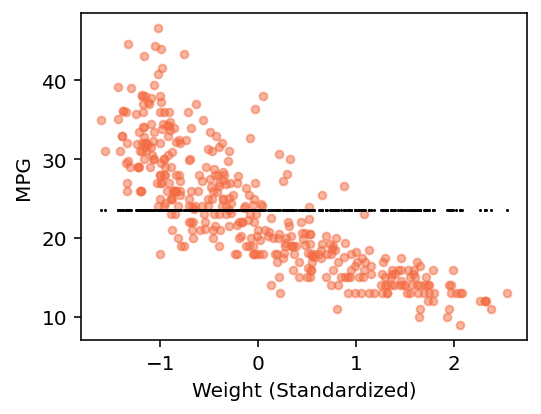

In [42]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Tanh(),       # gives smooth step function shape
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG)

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      583.105 MAE    22.90
Epoch   10 MSE loss      201.989 MAE    13.33
Epoch   20 MSE loss      113.766 MAE     8.80
Epoch   30 MSE loss       65.576 MAE     7.01
Epoch   40 MSE loss       42.494 MAE     5.39
Epoch   50 MSE loss       32.230 MAE     4.66
Epoch   60 MSE loss       30.012 MAE     4.35
Epoch   70 MSE loss       30.603 MAE     4.36
Epoch   80 MSE loss       30.022 MAE     4.35
Epoch   90 MSE loss       30.040 MAE     4.41
Epoch  100 MSE loss       29.959 MAE     4.37
LAST       MSE loss       29.959 MAE     4.37


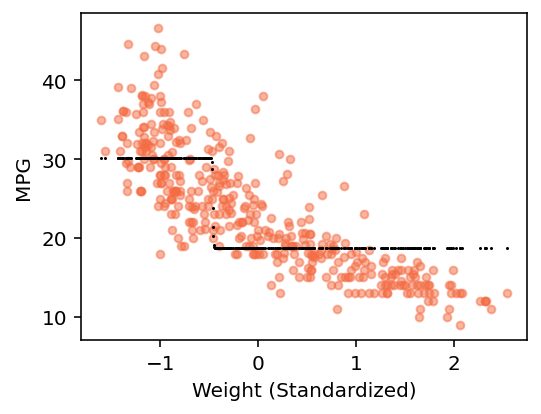

In [43]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=35, nepochs=100)

mshow(model, X=X, y=df_cars.MPG)

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      607.110 MAE    23.29
Epoch  200 MSE loss       16.226 MAE     2.97
Epoch  400 MSE loss       16.483 MAE     3.01
Epoch  600 MSE loss       17.072 MAE     2.98
Epoch  800 MSE loss       17.052 MAE     3.10
Epoch 1000 MSE loss       17.122 MAE     2.96
Epoch 1200 MSE loss       17.302 MAE     3.18
Epoch 1400 MSE loss       16.622 MAE     3.00
Epoch 1600 MSE loss       16.240 MAE     2.94
Epoch 1800 MSE loss       16.424 MAE     2.99
Epoch 2000 MSE loss       16.739 MAE     3.09
LAST       MSE loss       16.739 MAE     3.09


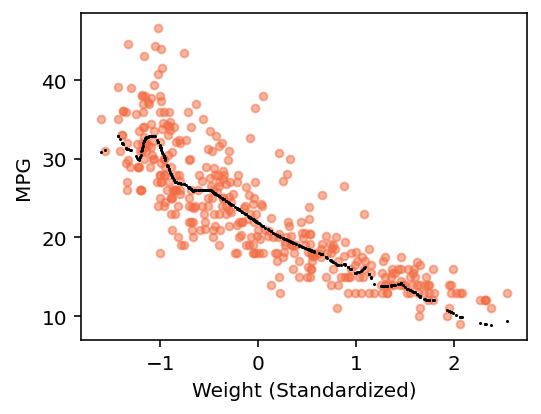

In [44]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model)

mshow(model, X=X, y=df_cars.MPG)

Epoch    0 MSE loss      625.047 MAE    23.80
Epoch  200 MSE loss       17.089 MAE     3.02
Epoch  400 MSE loss       17.009 MAE     3.02
Epoch  600 MSE loss       16.936 MAE     3.01
Epoch  800 MSE loss      135.907 MAE    10.00
Epoch 1000 MSE loss       17.076 MAE     3.01
Epoch 1200 MSE loss       16.883 MAE     3.01
Epoch 1400 MSE loss       31.246 MAE     4.32
Epoch 1600 MSE loss       16.862 MAE     3.00
Epoch 1800 MSE loss       16.707 MAE     2.99
Epoch 2000 MSE loss       16.648 MAE     2.98
LAST       MSE loss       16.648 MAE     2.98


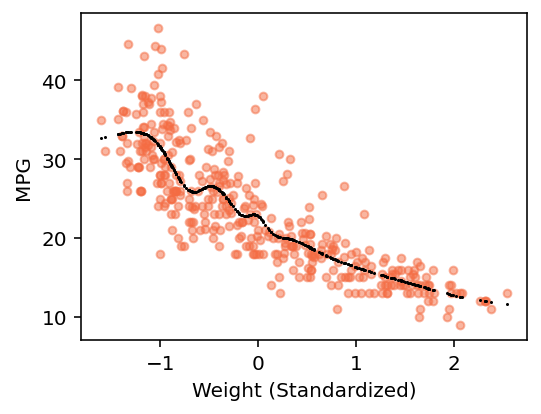

In [45]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model)

mshow(model, X=X, y=df_cars.MPG)